In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import tqdm
import random
from PIL import Image
train_on_gpu = True
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
try:
    import torchbearer
except:
    !pip install torchbearer
    import torchbearer
from torchbearer import Trial
import scipy
import scipy.special
import bagnets.pytorchnet
print("[libraries successfully installed...]")

[libraries successfully installed...]


In [3]:
# Top level data directory
data_dir = './flowers/'

# Save our result (model checkpoints, loss_acc data, plots)to this directory
saved_model_dir = './model_performance_results/bagnet33_baseline_results/'

model_name = 'bagnet33'

# Number of classes in  the dataset
num_classes = 5

# Batch size for training (standardized to BagNet baseline)
batch_size = 32

# Flag for feature extracting. When False, we finetune the whole model, when True we only update the reshaped layer params
feature_extract = True

In [4]:
#-------------------- Some Helper Functions ---------------------------#

# compute gradients for newly initialized layer
def set_parameter_requires_grad(model, feature_extracting):
    """
    This function sets all parameters of model to False, which means we don't fine
    tune all parameters but only feature extract and compute gradients
    for newly initialized layer.
    """
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    """
    This function initializes these variables which will be set in this
    if statement. Each of these variables is model specific.
    """
    model_ft = None

    if model_name == "bagnet9":
        model_ft = bagnets.pytorchnet.bagnet9(pretrained=use_pretrained)
    if model_name == "bagnet17":
        model_ft = bagnets.pytorchnet.bagnet17(pretrained=use_pretrained)
    if model_name == "bagnet33":
        model_ft = bagnets.pytorchnet.bagnet33(pretrained=use_pretrained)

    set_parameter_requires_grad(model_ft, feature_extract)

    # Change the last layer to match our number of classes
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    return model_ft

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("[Using", device , "...]")

[Using cpu ...]


In [5]:
#--------------------- Load test datasets ------------------------------#

print("==> [Preparing data ....]")

# Data augmentation and normalization for training
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),  # resize the image to 224*224 pixels
        transforms.CenterCrop(224),  # crop the image to 224*224 pixels about the center
        transforms.RandomHorizontalFlip(),  # convert the image to PyTorch Tensor data type
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Just normalization for validation
    "val": transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
train_data = torchvision.datasets.ImageFolder(data_dir + "train/", data_transforms["train"])
val_data = torchvision.datasets.ImageFolder(data_dir + "val/", data_transforms["val"])
test_data = torchvision.datasets.ImageFolder(data_dir + "test/", data_transforms["test"])

# Create training and validation dataloaders
dataloaders_dict = {"train": torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                    shuffle=True, num_workers=2),
                    "val": torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                    shuffle=False, num_workers=2),
                    "test": torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                    shuffle=False, num_workers=2)}

train_loader = dataloaders_dict['train']
val_loader = dataloaders_dict['val']
test_loader = dataloaders_dict['test']

==> [Preparing data ....]
Initializing Datasets and Dataloaders...


In [6]:
##------------------- Initialize Bagnet-33 model --------------------##

print('==> Bagnet-33 model')

model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Send the model to CPU
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
print("[Using CrossEntropyLoss ...]")
criterion = nn.CrossEntropyLoss()
print("[Bagnet33 model Initialized...]")

==> Bagnet-33 model
Params to learn:
	 fc.weight
	 fc.bias
[Using CrossEntropyLoss ...]
[Bagnet33 model Initialized...]


In [7]:
#---------------Load saved weights------------------------#
if torch.cuda.is_available():
    checkpoint = torch.load(saved_model_dir + "bagnet33_baseline_model.pth")
else:
    checkpoint = torch.load(saved_model_dir + "bagnet33_baseline_model.pth", map_location=torch.device('cpu'))
    
model_ft.load_state_dict(checkpoint['model_bagnet33_state_dict'])
optimizer_ft.load_state_dict(checkpoint['optimizer_bagnet33_state_dict'])
print("--------Saved Bagnet33 weights loaded--------------------")

--------Saved Bagnet33 weights loaded--------------------


In [8]:
#---------------Investigate performance on test datasets---------

print("--------Investigate performance on test datasets---------")
model_ft.eval()
trial = Trial(model_ft, optimizer_ft, criterion, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(train_loader, val_generator=val_loader, test_generator=test_loader)
predictions = trial.predict()
predicted_classes = predictions.argmax(1).cpu()

predictions

--------Investigate performance on test datasets---------


tensor([[ 9.4663e+00, -4.0800e+00, -2.2340e+00, -3.2600e-01, -3.7969e+00],
        [ 5.2859e+00, -2.3385e+00, -6.0996e-01, -1.9601e+00, -9.9134e-01],
        [ 2.4137e+00, -3.8712e+00,  2.3901e-01, -4.1165e-03,  6.1497e-01],
        ...,
        [-2.7060e+00, -1.6154e+00, -8.7537e-01,  1.0314e+00,  3.1629e+00],
        [-1.3215e+00, -3.4068e-01,  1.0007e+00, -2.5409e+00,  2.5773e+00],
        [-2.7387e+00, -3.1845e+00,  1.9753e+00, -4.0922e-01,  3.4867e+00]])

In [13]:
from sklearn.metrics import confusion_matrix
nb_classes = 5

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[65  6  2  2  0]
 [ 1 70  0  3  1]
 [ 1  0 68  1  5]
 [ 1  3  0 71  0]
 [ 0  1  2  3 69]]
[86.66666667 93.33333333 90.66666667 94.66666667 92.        ]


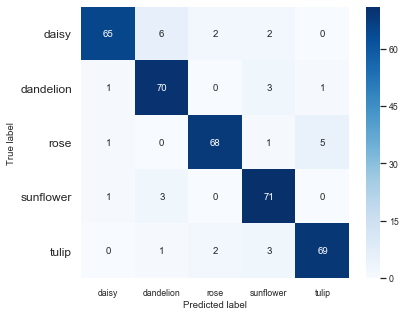

In [69]:
import seaborn as sns
figsize = (10,5)
fontsize=12
classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
df_cm = pd.DataFrame(conf_mat, index=classes, columns=classes)
fig = plt.figure(figsize=(6,5))
try:
    ax = sns.heatmap(df_cm, cmap="Blues", annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
ax.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
# heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
plt.ylabel('True label')
plt.xlabel('Predicted label')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.savefig("./paperwork/confusion_matrix.png")
